In [1]:
import os
import sys

import pandas as pd
import numpy as np
import typing

sys.path.append(os.path.abspath("../common"))  # add path to common functions
from evaluate import evaluate_predictions
from preprocess import getdfs, get_char_columns
from preprocess import one_hot_encode
from models import predict_logistic_regression
from models import grid_search_
from models import predict_xgboost

In [2]:
emo_df, emo_val_df = getdfs('emoticon')

In [3]:
emo_df = get_char_columns(emo_df)
emo_df.head()


,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,label
0,😛,🛐,😻,😑,😣,🙠,🙯,🚼,😒,🙼,😑,🙯,😣,0
1,🛐,😑,😪,😛,🚼,🙯,😣,🚅,😑,🙯,😹,😣,🙼,0
2,😛,🙯,😑,🚡,😣,🚼,🛐,🙲,😣,🙯,🛑,😑,🙼,0
3,😛,🚼,🛐,🙐,😣,🙯,😑,🙪,😑,🙼,🛆,😣,🙯,1
4,🛐,🚟,🚼,😛,🙋,😑,😣,🙯,😹,🙯,😑,😣,🙼,1


In [4]:

repeat_emos = ['🙼', '🛐', '🙯', '😛', '😣', '😑', '🚼']

repeat_emo_code = {
     '🙼' : '284',
     '🛐' : '464', 
     '🙯' : '262',
     '😛' : '15436', 
     '😣' : '614',
     '😑' : '1596', 
     '🚼' : '422'
}

In [6]:
train_df, valid_df = getdfs('text_seq')

In [7]:
def remove_substrings(input_string, substrings):
    """
    Removes all occurrences of substrings from the input string.

    Parameters:
    input_string (str): The string to remove substrings from.
    substrings (list): List of substrings to remove from the input string.

    Returns:
    str: The input string with substrings removed.
    """
    for substring in substrings:
        input_string = input_string.replace(substring, "")
    return input_string


In [8]:
def process_strings ( strs : typing.List[str] )-> typing.List[str]:
    strs = [x.lstrip('0') for x in strs]

    # Example usage
    substrings = repeat_emo_code.values()

    # Remove the substrings
    strs = [remove_substrings(input_string, substrings) for input_string in strs]

    padded_strs = []

    for s in strs:
        if len(s) < 15:
            s = s + '0'*(15-len(s))
        padded_strs.append(s)

    return padded_strs

In [9]:
train_df['input_str'] = process_strings(train_df['input_str'])
valid_df['input_str'] = process_strings(valid_df['input_str'])

In [10]:
train_df['input_str']

0       271828003132000
1       369511047476100
2       599913580405100
3       123889563510000
4       189920690476100
             ...       
7075    670271824140000
7076    155833493901000
7077    306994309179500
7078    198337758940000
7079    476119231899000
Name: input_str, Length: 7080, dtype: object

## Digit Distribution

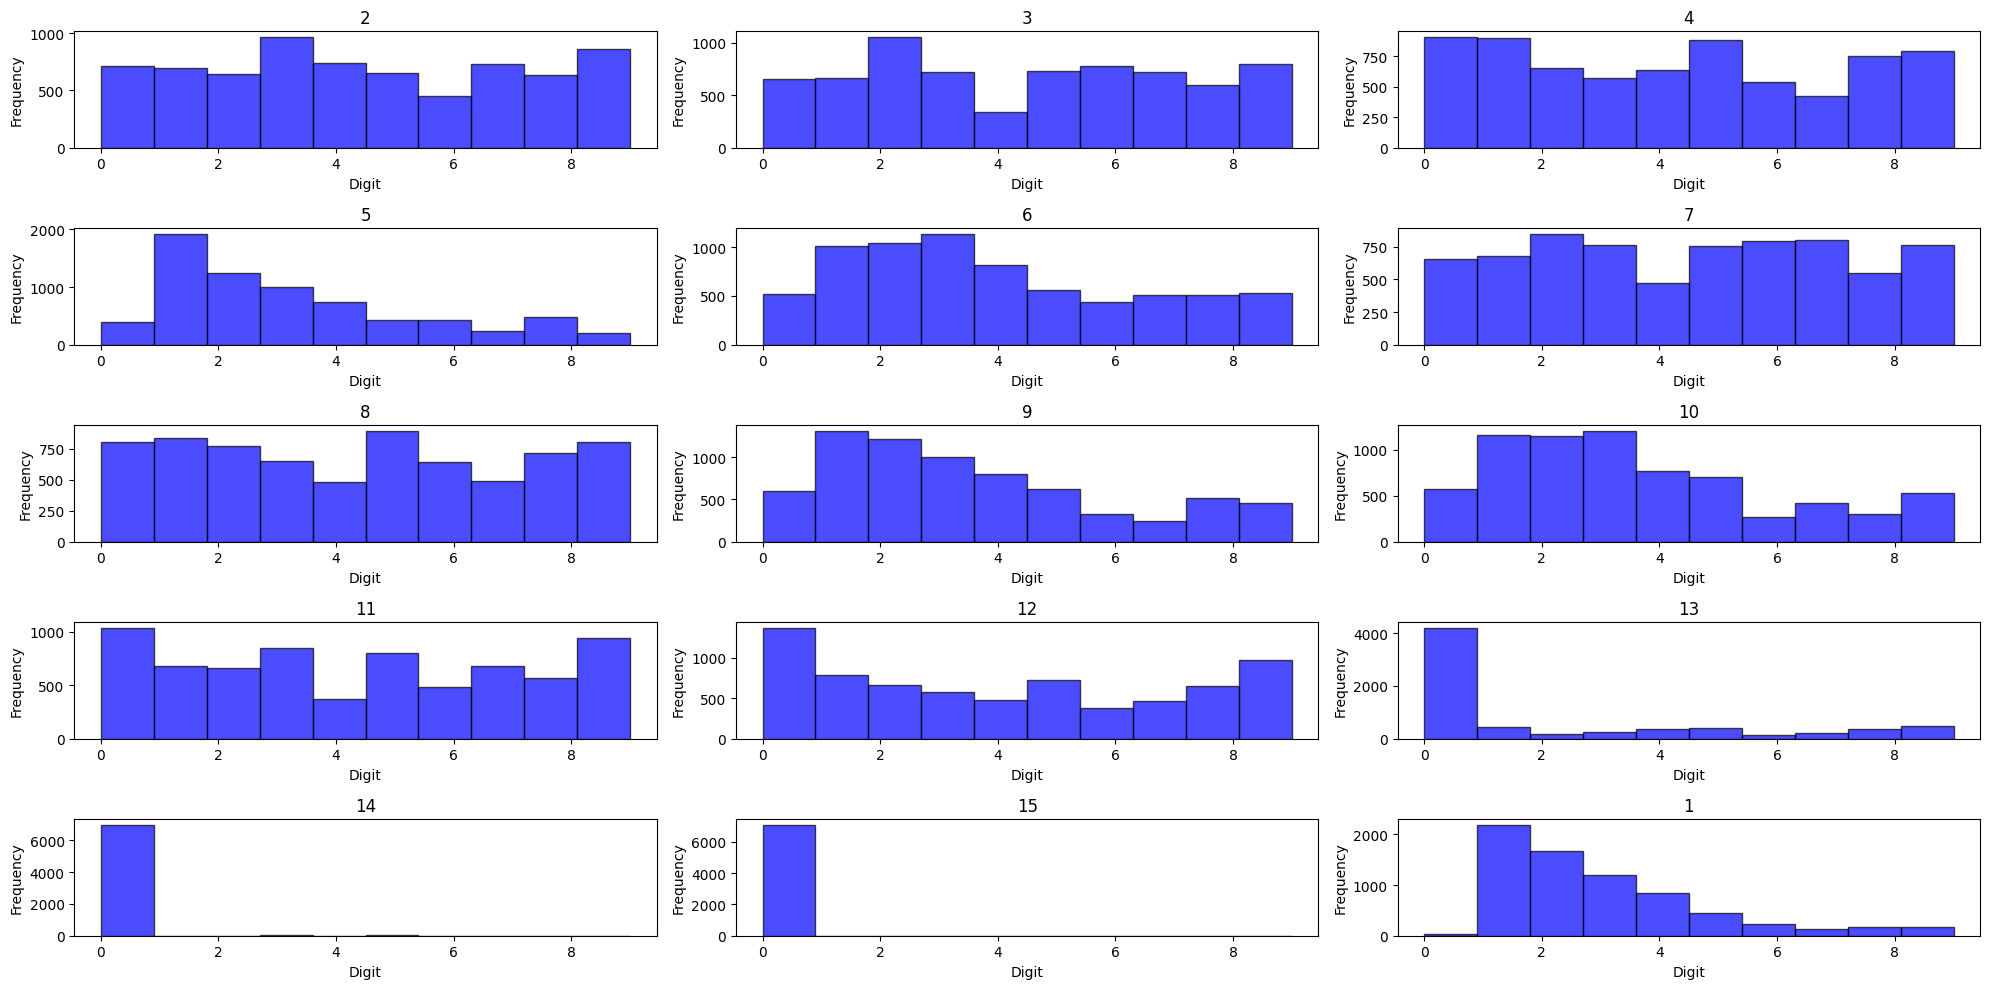

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming data is a list of strings
data = train_df['input_str'].to_list()

# Convert each string into individual digit columns
df = pd.DataFrame([list(map(int, list(s))) for s in data])

# Plot histograms for each feature
plt.subplots(5, 3, figsize=(20, 10))
for i in range(len(data[0])):
    plt.hist(df[i], bins=10, range=(0, 9), alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'{i+1}')
    plt.xlabel('Digit')
    plt.ylabel('Frequency')
    plt.subplot(5, 3, i+1)
plt.tight_layout()

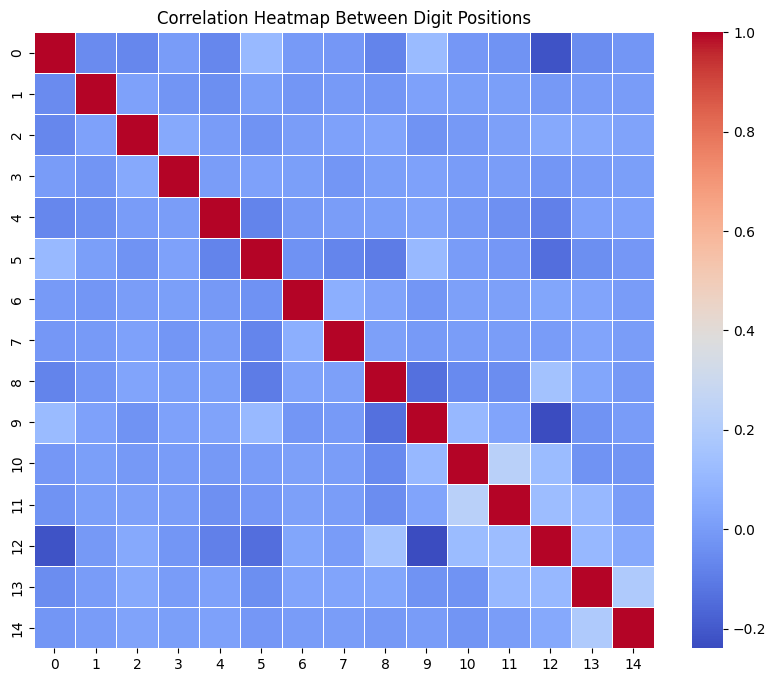

In [16]:
import seaborn as sns

# Compute the correlation matrix
corr_matrix = df.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap Between Digit Positions')
plt.show()


Almost no correlation in the entries

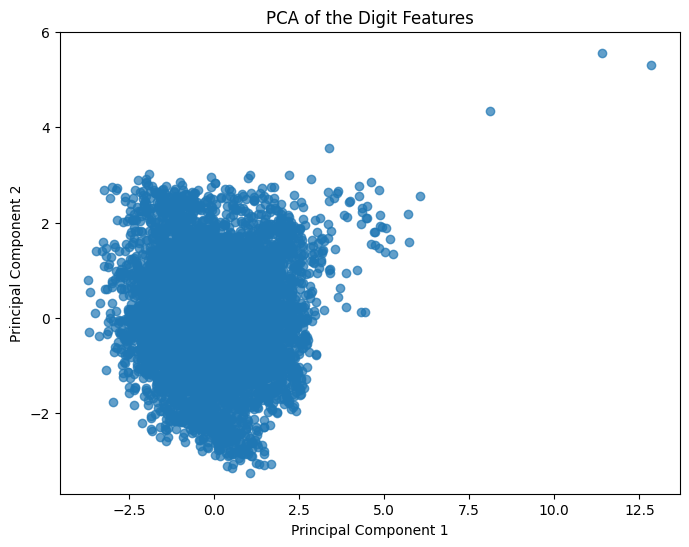

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the data (important for PCA)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Plot the PCA results
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
plt.title('PCA of the Digit Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


In [18]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with variance below a threshold
selector = VarianceThreshold(threshold=0.1)  # Example threshold
df_reduced = selector.fit_transform(df)


In [19]:
df_reduced.shape

(7080, 14)

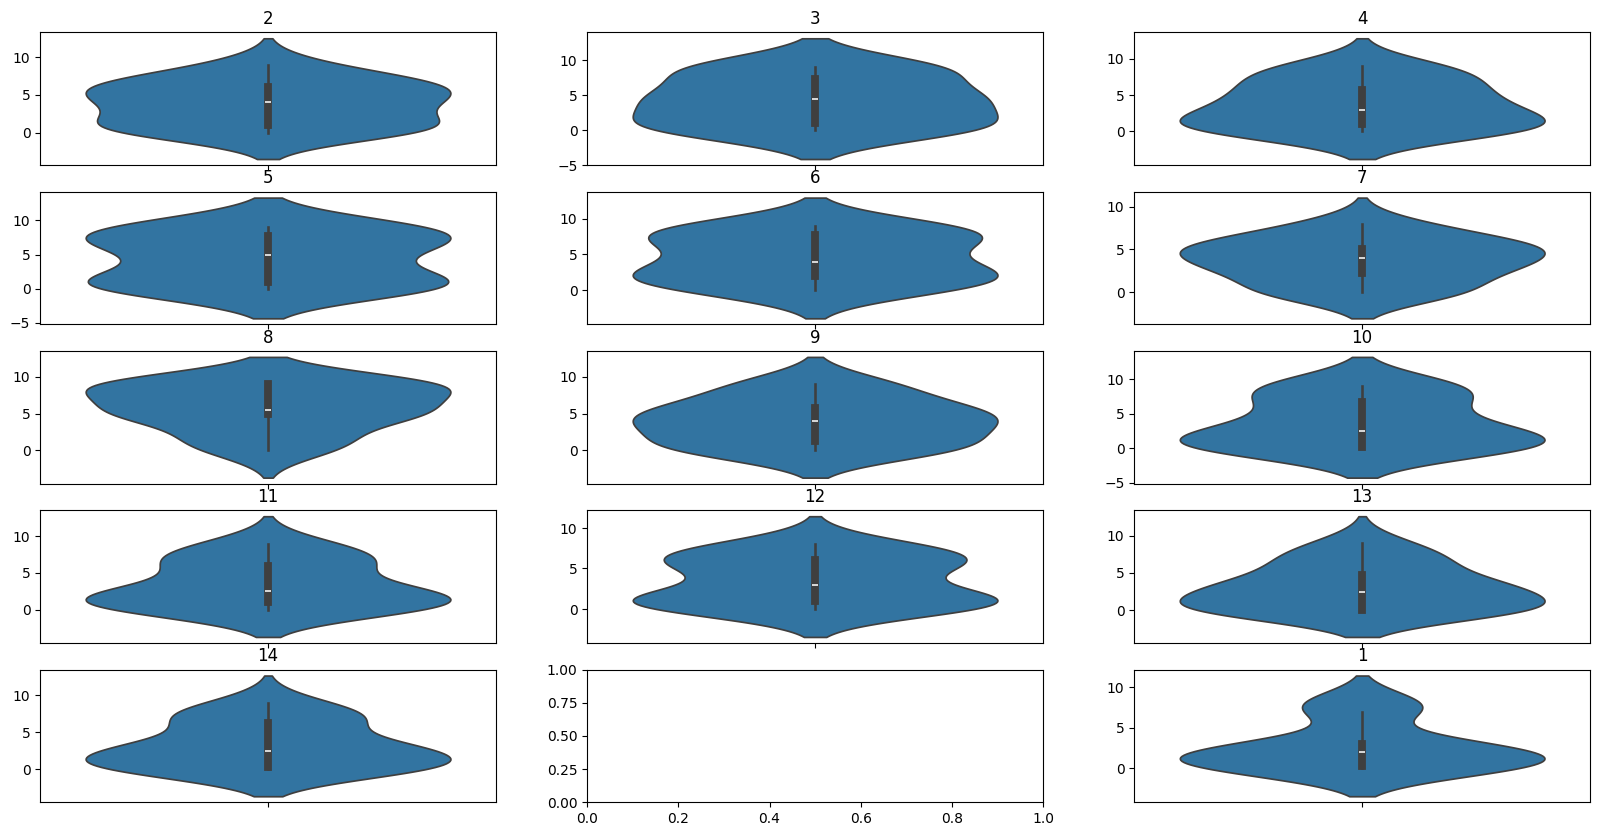

In [30]:
plt.subplots(5, 3, figsize=(20, 10))
for i in range((df_reduced.shape[1])):
    sns.violinplot(df_reduced[i])
    plt.title(f'{i+1}')
    plt.subplot(5, 3, i+1)
